In [22]:
%load_ext autoreload
%autoreload 2


import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from pvi.models.sgp import StochasticSparseGaussianProcessModel

import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch

from torch import nn
from gpytorch.kernels import ScaleKernel, RBFKernel

%matplotlib inline
torch.set_default_dtype(torch.float64)

# Set up data and helper functions

In [24]:
x = np.linspace(-1, 1, 50)
y = 2 * np.sin(5*x) + 3 * np.abs(x) * np.random.rand(len(x))

x = torch.tensor(x).unsqueeze(1)
y = torch.tensor(y).unsqueeze(1)

In [25]:
def plot_data(x, y):
    plt.figure()
    plt.grid(b=True)
    plt.scatter(x, y)
    plt.show()
    
def plot_results(x, y, model):
    pp = model(x)
    mean = pp.mean.detach()
    std = pp.variance.detach() ** 0.5
    
    samples = pp.sample((20,))
    
    plt.figure()
    plt.grid(b=True)
    
    for sample in samples:
        plt.plot(x, sample, color='k', alpha=.1)
        
    plt.plot(x.squeeze(-1), mean)
    plt.fill_between(x.squeeze(-1), mean-1.96*std, mean+1.96*std, alpha=.25)
    plt.scatter(x, y)
    plt.show()
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure()
    plt.grid(b=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()
    
data = {
    "x": x,
    "y": y,
}

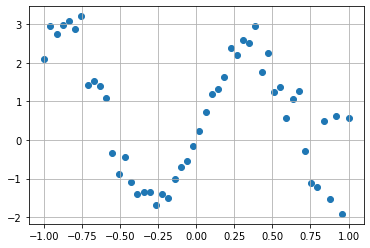

In [26]:
plot_data(x, y)

# Construct SGP model

In [41]:
hyperparameters = {
    "D": 1,
    "num_inducing": 5,
    "kernel_class": RBFKernel,
    "kernel_params": {"lengthscale": .5},
    "epochs": 5000,
    "optimiser_params": {"lr": 1e-4},
    "batch_size": 50
}

inducing_locations = x[::10].clone()

model = StochasticSparseGaussianProcessModel(
    inducing_locations=inducing_locations,  output_sigma=.5, 
    hyperparameters=hyperparameters)

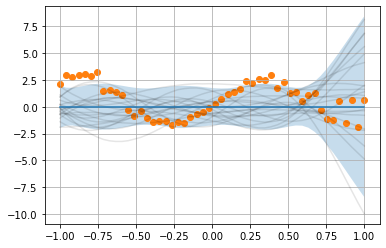

In [42]:
plot_results(x, y, model)

# Fit data

In [8]:
t = {
    "np1": torch.tensor([0.]*model.hyperparameters["num_inducing"]),
    "np2": torch.tensor([0.]*model.hyperparameters["num_inducing"]).diag_embed()
}

In [9]:
t_new = model.fit(data, t)

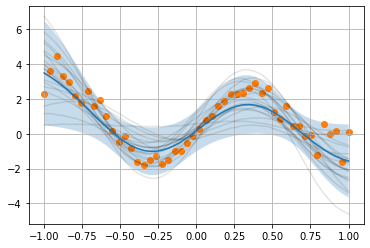

In [10]:
plot_results(x, y, model)

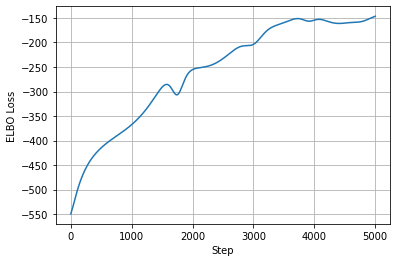

In [11]:
plot_training(model._training_curves[0]["elbo"])

In [12]:
for name, param in model.named_parameters():
    print(name, param)

prec_chol Parameter containing:
tensor([[ 1.0000, -0.5786, -0.0421, -0.1529,  0.2818],
        [-0.5169,  1.5788,  0.2389, -0.3586,  0.2033],
        [ 0.2204,  0.4163,  1.6349,  0.1864, -0.1993],
        [-0.5110, -0.4495,  0.1673,  1.6168,  0.1263],
        [ 0.2189, -0.5192, -0.0376, -0.2463,  1.6511]], requires_grad=True)
np1 Parameter containing:
tensor([ 0.6854,  0.6693, -0.6314,  0.6400,  0.6492], requires_grad=True)
inducing_locations Parameter containing:
tensor([[-1.5883],
        [-0.8623],
        [-0.2800],
        [ 0.3674],
        [ 0.8172]], requires_grad=True)
kernel.raw_lengthscale Parameter containing:
tensor([[-0.6074]], requires_grad=True)


In [13]:
model.nat_params

{'np1': Parameter containing:
 tensor([ 0.6854,  0.6693, -0.6314,  0.6400,  0.6492], requires_grad=True),
 'np2': tensor([[-0.7197,  0.6642,  0.0870,  0.2348, -0.5119],
         [ 0.6642, -1.4934, -0.4133,  0.4798,  0.2589],
         [ 0.0870, -0.4133, -1.4846, -0.1250,  0.3022],
         [ 0.2348,  0.4798, -0.1250, -1.5606,  0.0372],
         [-0.5119,  0.2589,  0.3022,  0.0372, -1.5528]], grad_fn=<MulBackward0>)}

Parameter containing:
tensor([[0.]], requires_grad=True)